In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# develop a time series arima forecasting model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('subscription_payments_by_date.csv', sep=';', parse_dates=['date'])
df['total_amount'] = df['total_amount'].astype(float)
print(df.dtypes)
print(df.head())
print(df.tail())

date            datetime64[ns]
total_amount           float64
dtype: object
        date  total_amount
0 2021-06-30         521.0
1 2021-07-01         621.0
2 2021-07-02         342.0
3 2021-07-03         537.0
4 2021-07-04         273.0
          date  total_amount
872 2023-11-19        2667.0
873 2023-11-20        3085.0
874 2023-11-21        3495.0
875 2023-11-22        2553.0
876 2023-11-23        1166.0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_amount,877.0,1555.144812,1018.57011,108.0,756.0,1232.0,2250.0,6065.0


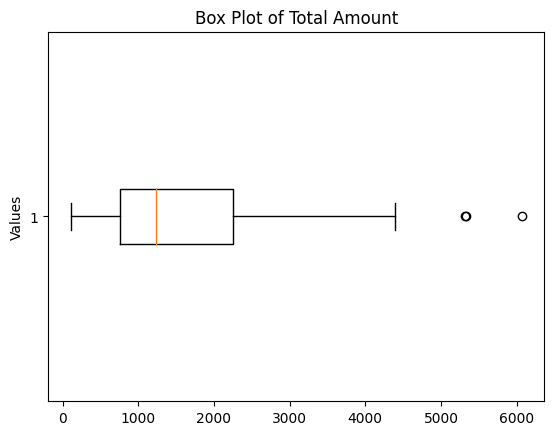

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(df['total_amount'],vert=False)
plt.title('Box Plot of Total Amount')
plt.ylabel('Values')
plt.show()

In [ ]:
from scipy.stats import ttest_ind

# Split the data into two groups: before and after July 2023
before_july_2023 = df[df['date'] < '2023-07-01']['total_amount']
after_july_2023 = df[df['date'] >= '2023-07-01']['total_amount']

# Perform a t-test
t_stat, p_value = ttest_ind(before_july_2023, after_july_2023)

print(f'T-statistic: {t_stat}')
print(f'p-value: {p_value}')

T-statistic: -13.848735753602384
p-value: 1.3984509749100331e-39


In [ ]:
# Convert the 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Calculate the mean before July 2023
mean_before_july_2023 = df[df['date'] < '2023-07-01']['total_amount'].mean()

# Calculate the mean after July 2023
mean_after_july_2023 = df[df['date'] >= '2023-07-01']['total_amount'].mean()

print(f'Mean before July 2023: {mean_before_july_2023}')
print(f'Mean after July 2023: {mean_after_july_2023}')

Mean before July 2023: 1362.2448700410396
Mean after July 2023: 2520.9657534246576


## ARIMA

In [ ]:
df_ar = pd.read_csv('subscription_payments_by_date.csv', sep=';', parse_dates=['date'],header=0, index_col=0)
# df_ar['total_amount'] = df_ar['total_amount'].diff()
df_ar.head()

,total_amount
date,
2021-06-30,521
2021-07-01,621
2021-07-02,342
2021-07-03,537
2021-07-04,273


In [ ]:
df_ar.shape

(877, 1)

In [ ]:
df_ar.dtypes

total_amount    int64
dtype: object

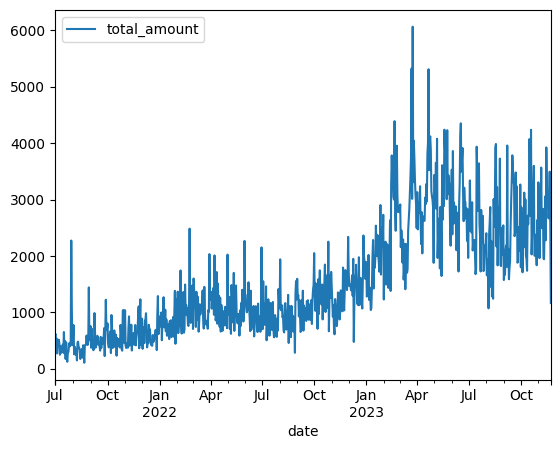

In [ ]:
df_ar.plot()
plt.show()


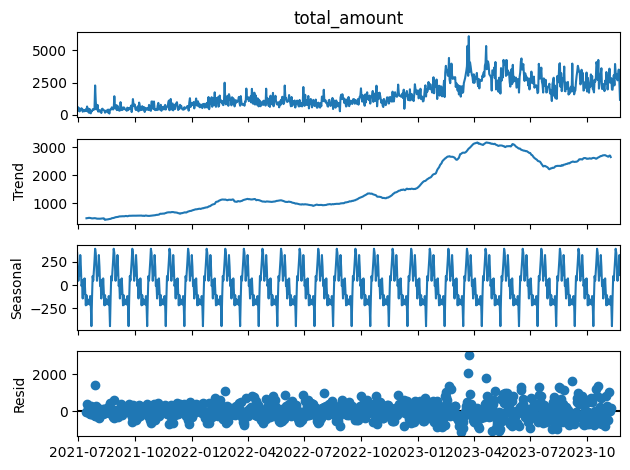

In [ ]:
# data analysis
# time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_ar['total_amount'], period=30)
result.plot()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_ar['total_amount'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.366094
p-value: 0.598419
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Here we can see that the p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary. Let’s make a plot of this data

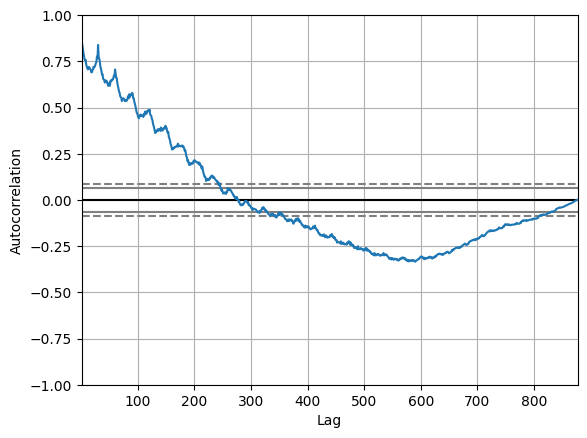

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_ar)
plt.show()

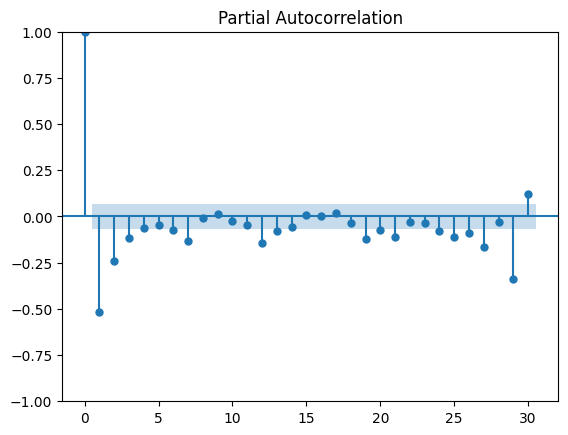

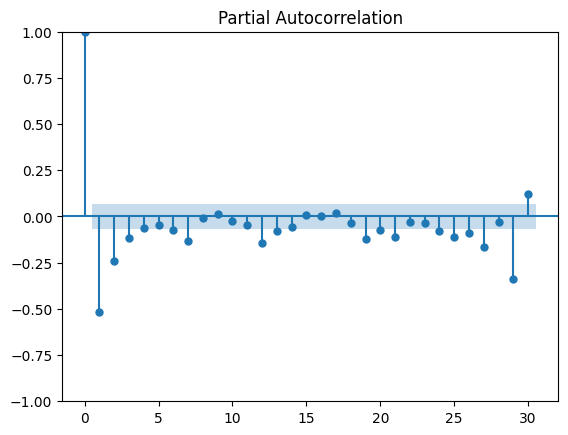

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_ar.total_amount.diff().dropna())

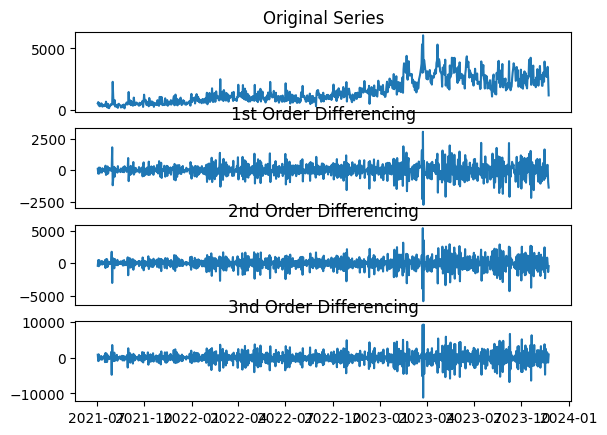

In [ ]:
fig, (ax1, ax2, ax3,ax4) = plt.subplots(4)
ax1.plot(df_ar.total_amount); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_ar.total_amount.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_ar.total_amount.diff().diff()); ax3.set_title('2nd Order Differencing'); ax3.axes.xaxis.set_visible(False)
ax4.plot(df_ar.total_amount.diff().diff().diff()); ax4.set_title('3nd Order Differencing')
plt.show()

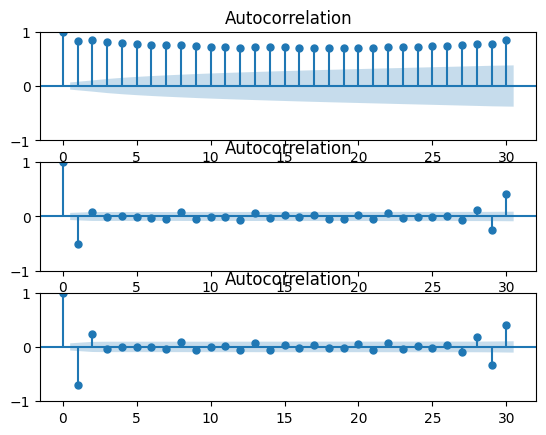

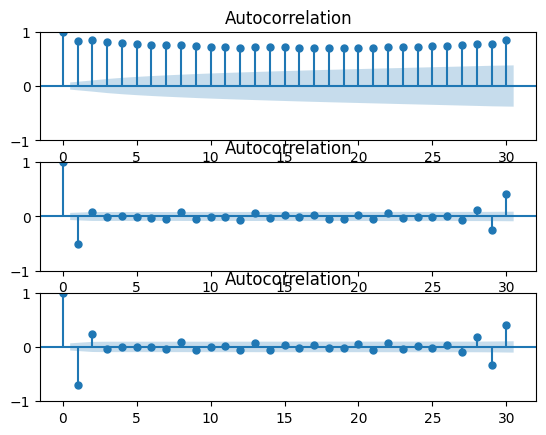

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_ar.total_amount, ax=ax1)
plot_acf(df_ar.total_amount.diff().dropna(), ax=ax2)
plot_acf(df_ar.total_amount.diff().diff().dropna(), ax=ax3)

Here we can see that in second-order differencing the immediate lag has gone on the negative side, representing that in the second-order the series has become over the difference.

                               SARIMAX Results                                
Dep. Variable:           total_amount   No. Observations:                  877
Model:                ARIMA(10, 1, 1)   Log Likelihood               -6607.787
Date:                Fri, 01 Dec 2023   AIC                          13239.575
Time:                        19:08:35   BIC                          13296.879
Sample:                    06-30-2021   HQIC                         13261.494
                         - 11-23-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1836      0.033      5.587      0.000       0.119       0.248
ar.L2          0.2466      0.028      8.707      0.000       0.191       0.302
ar.L3          0.1102      0.035      3.188      0.0

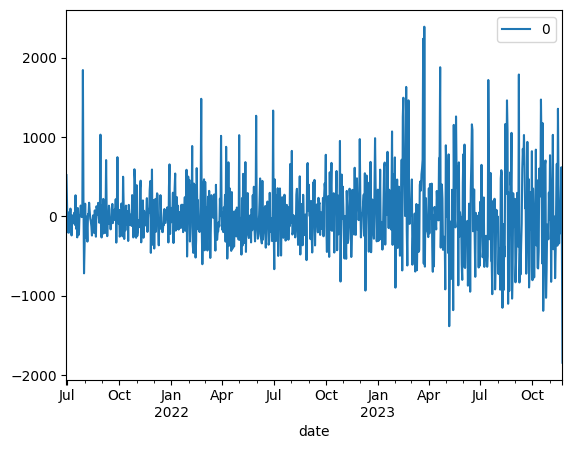

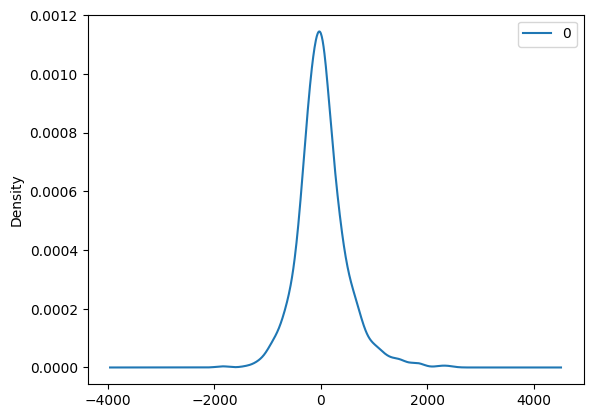

                 0
count   877.000000
mean     25.336694
std     456.075572
min   -1843.267316
25%    -229.902833
50%      -6.281066
75%     231.612652
max    2391.775631


In [ ]:

# fit model
model = ARIMA(df_ar, order=(10,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

predicted=2671.088606, expected=2250.000000
predicted=2523.608259, expected=1883.000000
predicted=2378.707759, expected=2295.000000
predicted=2341.062698, expected=1583.000000
predicted=2210.326667, expected=1773.000000
predicted=2122.960981, expected=2217.000000
predicted=2093.123965, expected=1411.000000
predicted=1995.756404, expected=1935.000000
predicted=1995.373782, expected=2210.000000
predicted=2048.995262, expected=1703.000000
predicted=2053.018172, expected=1769.000000
predicted=1978.192389, expected=2454.000000
predicted=2108.472380, expected=2639.000000
predicted=2267.364279, expected=2826.000000
predicted=2354.183514, expected=3096.000000
predicted=2623.936849, expected=3386.000000
predicted=2922.464146, expected=3744.000000
predicted=3082.034131, expected=5324.000000
predicted=3648.422021, expected=3013.000000
predicted=3612.024836, expected=6065.000000
predicted=4204.987806, expected=3308.000000
predicted=4227.958408, expected=4045.000000
predicted=3884.684557, expected=

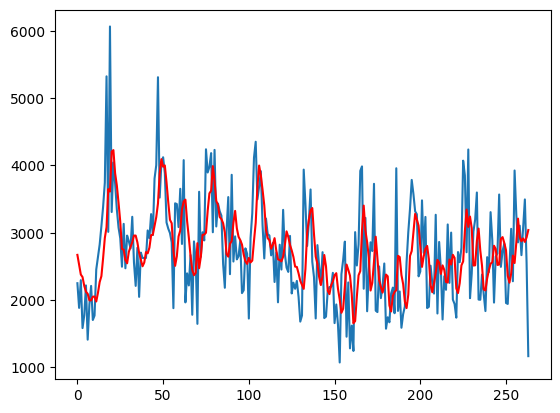

In [ ]:
# split into train and test sets
X = df_ar.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(10,1,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
len(predictions)

264

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [2, 4, 5, 6]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(df_ar.values, p_values, d_values, q_values)

ARIMA(2, 0, 0) MSE=465769.170
ARIMA(2, 0, 1) MSE=470949.966
ARIMA(2, 1, 0) MSE=462600.234
ARIMA(2, 1, 1) MSE=457609.965
ARIMA(4, 0, 0) MSE=471202.271
ARIMA(4, 0, 1) MSE=462890.534
ARIMA(4, 1, 0) MSE=480192.067
ARIMA(4, 1, 1) MSE=453186.643
ARIMA(5, 0, 0) MSE=475838.829
ARIMA(5, 0, 1) MSE=468843.922
ARIMA(5, 1, 0) MSE=480680.563
ARIMA(5, 1, 1) MSE=466985.827
ARIMA(6, 0, 0) MSE=476795.714
ARIMA(6, 1, 0) MSE=478744.109
ARIMA(6, 1, 1) MSE=448426.732
Best ARIMA(6, 1, 1) MSE=448426.732


## PROPHET

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# rename the columns as 'ds' and 'y'
df = df.rename(columns={'date': 'ds', 'total_amount': 'y'})

# Initialize and fit the model
model = Prophet()
model.fit(df)

# Make predictions for the next 365 days
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Calculate metrics
actual = df['y']
predicted = forecast['yhat'][:len(df)]
mse = mean_squared_error(actual, predicted)
rmse = sqrt(mse)
mae = mean_absolute_error(actual, predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/z0q2ethp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/8fwtu24_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13839', 'data', 'file=/tmp/tmphjtmo85o/z0q2ethp.json', 'init=/tmp/tmphjtmo85o/8fwtu24_.json', 'output', 'file=/tmp/tmphjtmo85o/prophet_model4n7hxwn8/prophet_model-20231204194103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 234746.48134263788
RMSE: 484.5064306514805
MAE: 344.1362396632963


In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, period='90 days', horizon = '30 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2022-07-31 00:00:00 and 2023-10-24 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/swa40v69.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/349nnjhx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81564', 'data', 'file=/tmp/tmphjtmo85o/swa40v69.json', 'init=/tmp/tmphjtmo85o/349nnjhx.json', 'output', 'file=/tmp/tmphjtmo85o/prophet_modelndff56so/prophet_model-20231204194123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/f77nag3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/z9ac9xjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-08-01,942.245799,578.247496,1328.244825,1076.0,2022-07-31
1,2022-08-02,934.428224,570.951178,1310.413549,1941.0,2022-07-31
2,2022-08-03,982.869710,619.216737,1326.110199,1041.0,2022-07-31
3,2022-08-04,951.863975,595.778793,1328.162743,1059.0,2022-07-31
4,2022-08-05,923.390088,574.443435,1270.623574,1127.0,2022-07-31
...,...,...,...,...,...,...
175,2023-11-19,2675.710943,2021.034253,3265.332581,2667.0,2023-10-24
176,2023-11-20,2827.318565,2256.876707,3466.233784,3085.0,2023-10-24
177,2023-11-21,2817.034891,2243.429112,3463.188866,3495.0,2023-10-24
178,2023-11-22,2855.132274,2242.744774,3458.922169,2553.0,2023-10-24


from matplotlib import pyplot as plt
df_cv['yhat'].plot(kind='hist', bins=20, title='yhat')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_cv['yhat_lower'].plot(kind='hist', bins=20, title='yhat_lower')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_cv['yhat_upper'].plot(kind='hist', bins=20, title='yhat_upper')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_cv['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_cv.plot(kind='scatter', x='yhat', y='yhat_lower', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_cv.plot(kind='scatter', x='yhat_lower', y='yhat_upper', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_cv.plot(kind='scatter', x='yhat_upper', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cv.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat_lower']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cv.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat_lower')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['yhat_upper']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cv.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('yhat_upper')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_cv.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
df_cv['yhat'].plot(kind='line', figsize=(8, 4), title='yhat')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_cv['yhat_lower'].plot(kind='line', figsize=(8, 4), title='yhat_lower')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_cv['yhat_upper'].plot(kind='line', figsize=(8, 4), title='yhat_upper')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_cv['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Python
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(100)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,60814.404640,246.605768,216.232879,0.318024,0.281200,0.384429,0.833333
1,4 days,80531.758944,283.781181,247.231399,0.403536,0.482183,0.436740,0.833333
2,5 days,69309.189459,263.266385,225.359652,0.395081,0.496678,0.463354,0.833333
3,6 days,67412.905425,259.639953,216.967445,0.393817,0.496678,0.463885,0.833333
4,7 days,72561.910871,269.373181,227.478866,0.411110,0.527016,0.517387,0.666667
5,8 days,88069.063408,296.764323,266.934482,0.500871,0.605779,0.705186,0.500000
6,9 days,156663.746422,395.807714,323.829246,0.544620,0.659625,0.837966,0.333333
7,10 days,158174.911143,397.712096,290.848286,0.478026,0.508234,0.853198,0.500000
8,11 days,158489.918703,398.107923,300.814352,0.485605,0.530970,0.805874,0.666667
9,12 days,78828.330966,280.763835,214.447536,0.433431,0.464163,0.665756,0.833333


In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
cutoffs = pd.to_datetime(['2021-08-15', '2022-06-15','2022-12-15','2023-07-15'])
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(model, horizon='44 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/5saziex3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphjtmo85o/ea6xaog5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35597', 'data', 'file=/tmp/tmphjtmo85o/5saziex3.json', 'init=/tmp/tmphjtmo85o/ea6xaog5.json', 'output', 'file=/tmp/tmphjtmo85o/prophet_model2ik7mzgt/prophet_model-20231204200015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:00:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  714.801063
1                     0.001                     0.10  714.801063
2                     0.001                     1.00  714.801063
3                     0.001                    10.00  714.801063
4                     0.010                     0.01  714.801063
5                     0.010                     0.10  714.801063
6                     0.010                     1.00  714.801063
7                     0.010                    10.00  714.801063
8                     0.100                     0.01  714.801063
9                     0.100                     0.10  714.801063
10                    0.100                     1.00  714.801063
11                    0.100                    10.00  714.801063
12                    0.500                     0.01  714.801063
13                    0.500                     0.10  714.801063
14                    0.5

In [ ]:
df_cv.shape

(264, 6)

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


In [ ]:

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
1212,2024-10-24,3726.060779,2989.464937,4399.472623
1213,2024-10-25,3698.508329,3003.241807,4428.545846
1214,2024-10-26,3654.770634,2920.461408,4375.058190
1215,2024-10-27,3592.648315,2890.630156,4333.748817
1216,2024-10-28,3726.332530,3052.564363,4498.446751
1217,2024-10-29,3666.116441,2959.663650,4375.459756
1218,2024-10-30,3671.926601,3024.734950,4375.604026
1219,2024-10-31,3659.421979,2969.491425,4360.204060
1220,2024-11-01,3624.974715,2908.820385,4336.411685
1221,2024-11-02,3576.286466,2818.494133,4252.341235


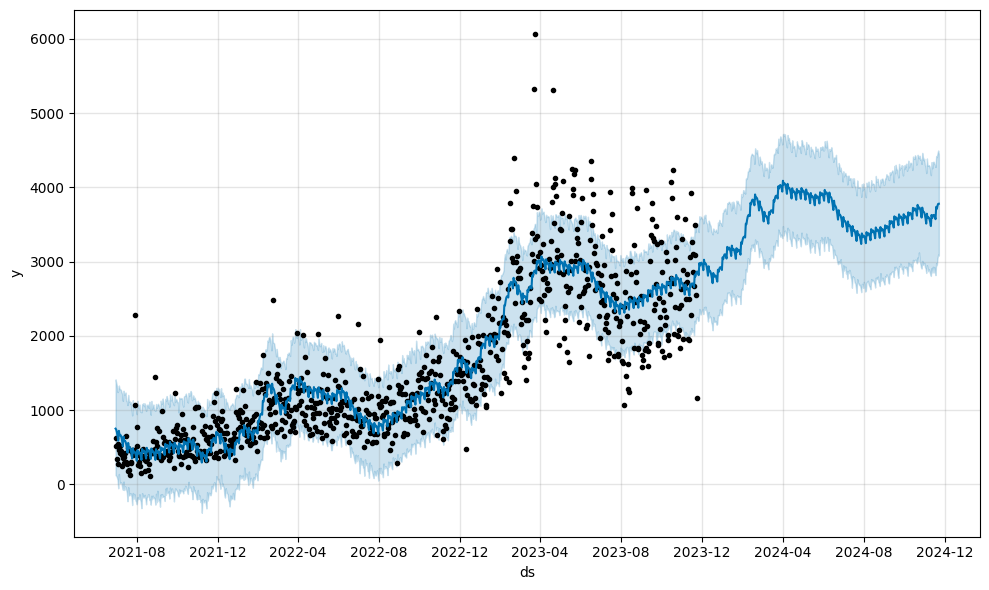

In [ ]:
# plot forecast
fig1 = model.plot(forecast)
plt.show()


**Adding ChangePoints to Prophet **


Changepoints are the datetime points where the time series have abrupt changes in the trajectory.

By default, Prophet adds 25 changepoints to the initial 80% of the data-set.

Let’s plot the vertical lines where the potential changepoints occurred.

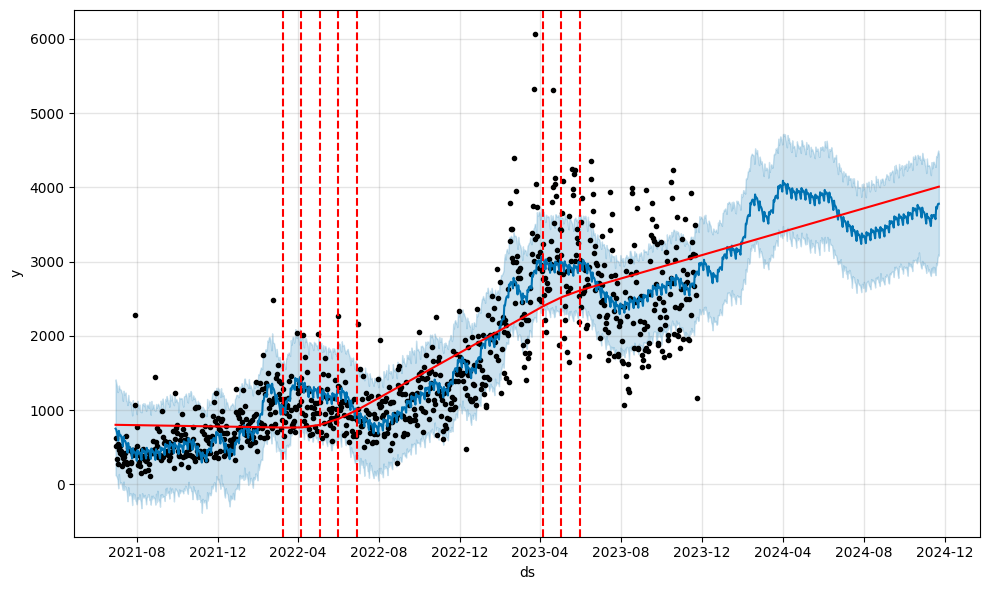

In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
model.changepoints

28    2021-07-28
56    2021-08-25
84    2021-09-22
112   2021-10-20
140   2021-11-17
168   2021-12-15
196   2022-01-12
224   2022-02-09
252   2022-03-09
280   2022-04-06
308   2022-05-04
336   2022-06-01
364   2022-06-29
392   2022-07-27
420   2022-08-24
448   2022-09-21
476   2022-10-19
504   2022-11-16
532   2022-12-14
560   2023-01-11
588   2023-02-08
616   2023-03-08
644   2023-04-05
672   2023-05-03
700   2023-05-31
Name: ds, dtype: datetime64[ns]

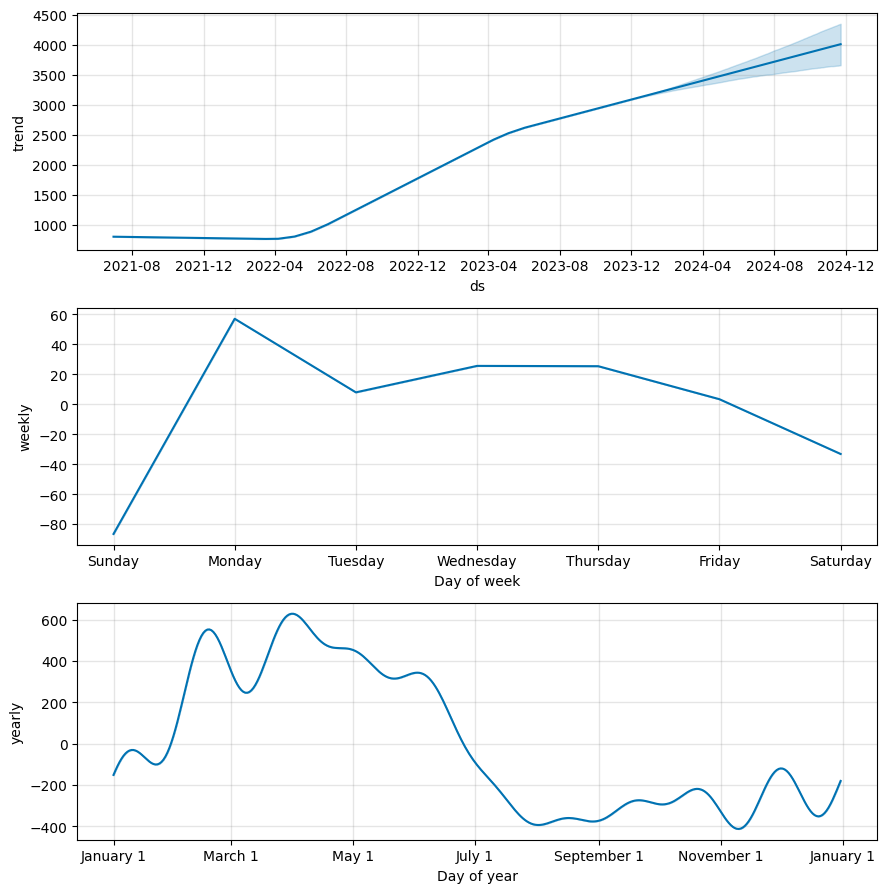

In [ ]:
# plot forecast components
fig2 = model.plot_components(forecast)
plt.show()


In [ ]:
# Calculate metrics
actual = df_pr['y']
predicted = forecast['yhat'][:len(df_pr)]
mse = mean_squared_error(actual, predicted)
rmse = sqrt(mse)
mae = mean_absolute_error(actual, predicted)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')



MAE: 344.35888984498354
MSE: 234901.0406223189
RMSE: 484.6659061893243


In [ ]:
#model evulation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
mae = mean_absolute_error(test, predictions)
print('MAE: %f' % mae)
mse = mean_squared_error(test, predictions)
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)


MAE: 519.113849
MSE: 439477.540615
RMSE: 662.931023


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgftqsmyb/c17wvcyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgftqsmyb/e8h9bzcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9883', 'data', 'file=/tmp/tmpgftqsmyb/c17wvcyp.json', 'init=/tmp/tmpgftqsmyb/e8h9bzcu.json', 'output', 'file=/tmp/tmpgftqsmyb/prophet_modelvb_rkxie/prophet_model-20231203125946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:59:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


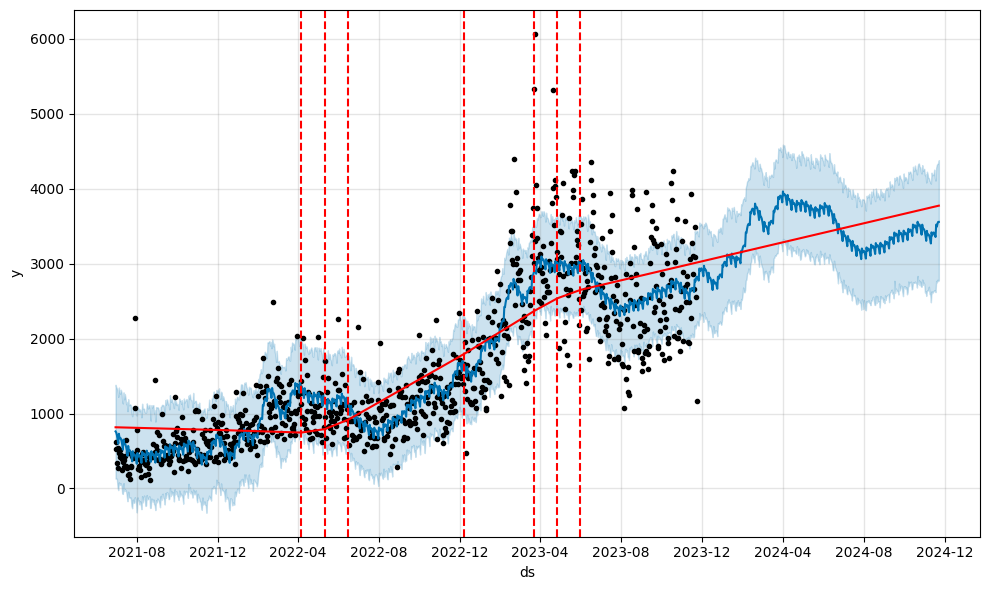

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzszqeyec/tv1t1yos.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzszqeyec/u4zeu4th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99417', 'data', 'file=/tmp/tmpzszqeyec/tv1t1yos.json', 'init=/tmp/tmpzszqeyec/u4zeu4th.json', 'output', 'file=/tmp/tmpzszqeyec/prophet_model50z1k240/prophet_model-20231202204402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


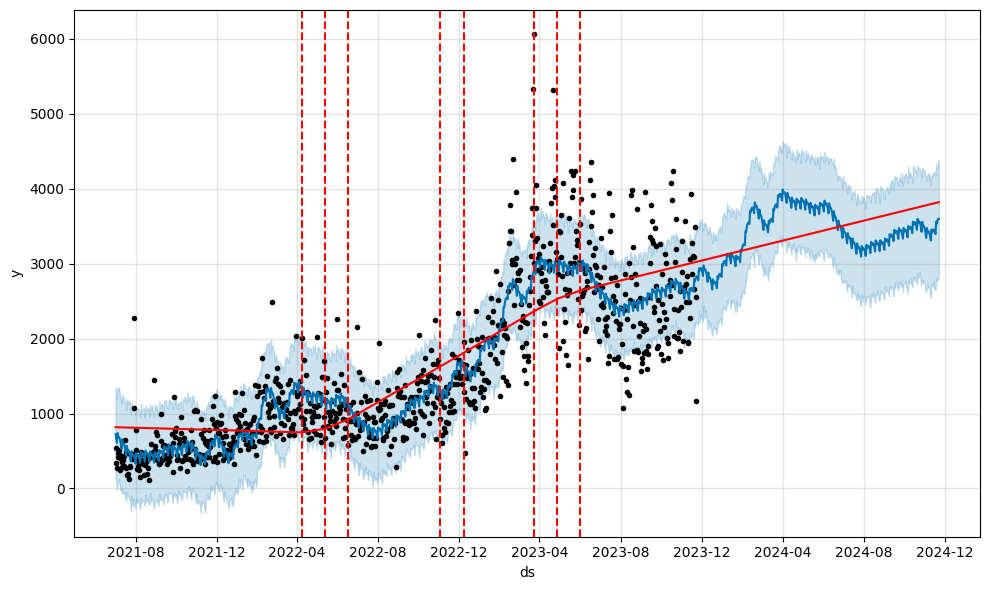

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzszqeyec/kzwfs70y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzszqeyec/udy1azpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10490', 'data', 'file=/tmp/tmpzszqeyec/kzwfs70y.json', 'init=/tmp/tmpzszqeyec/udy1azpz.json', 'output', 'file=/tmp/tmpzszqeyec/prophet_modelv2rj72dc/prophet_model-20231202204545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


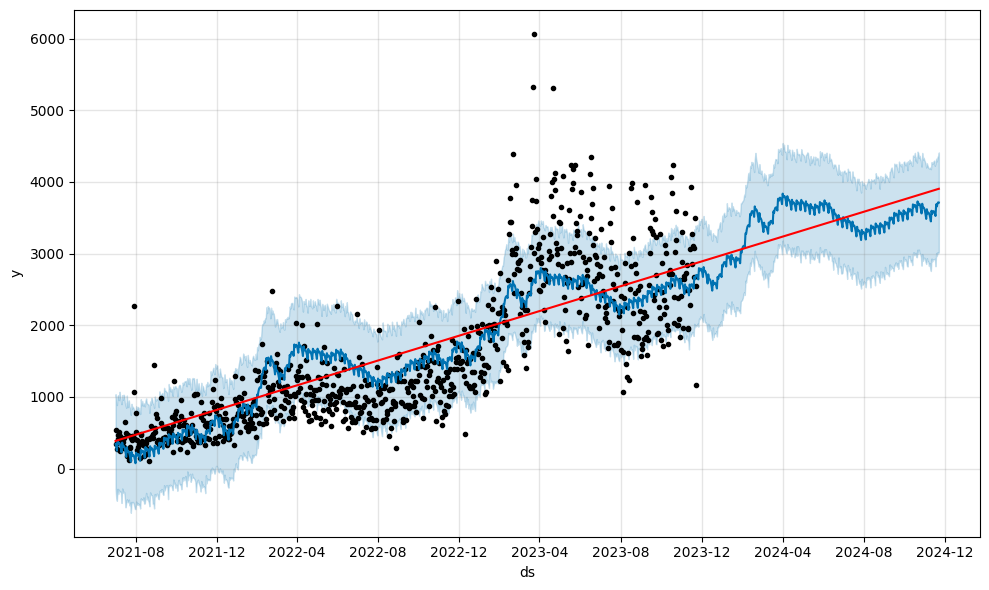

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

## SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df['total_amount_diff'] = df['total_amount'].diff()
df = df.dropna()

model_sarima = SARIMAX(df['total_amount_diff'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model_sarima.fit()


13219.41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5207      0.021    -25.099      0.000      -0.561      -0.480
ma.L1         -1.0000      0.177     -5.650      0.000      -1.347      -0.653
ar.S.L12      -0.0700      0.029     -2.409      0.016      -0.127      -0.013
ma.S.L12      -0.9983      0.175     -5.707      0.000      -1.341      -0.655
sigma2       2.47e+05   7.17e-07   3.44e+11      0.000    2.47e+05    2.47e+05


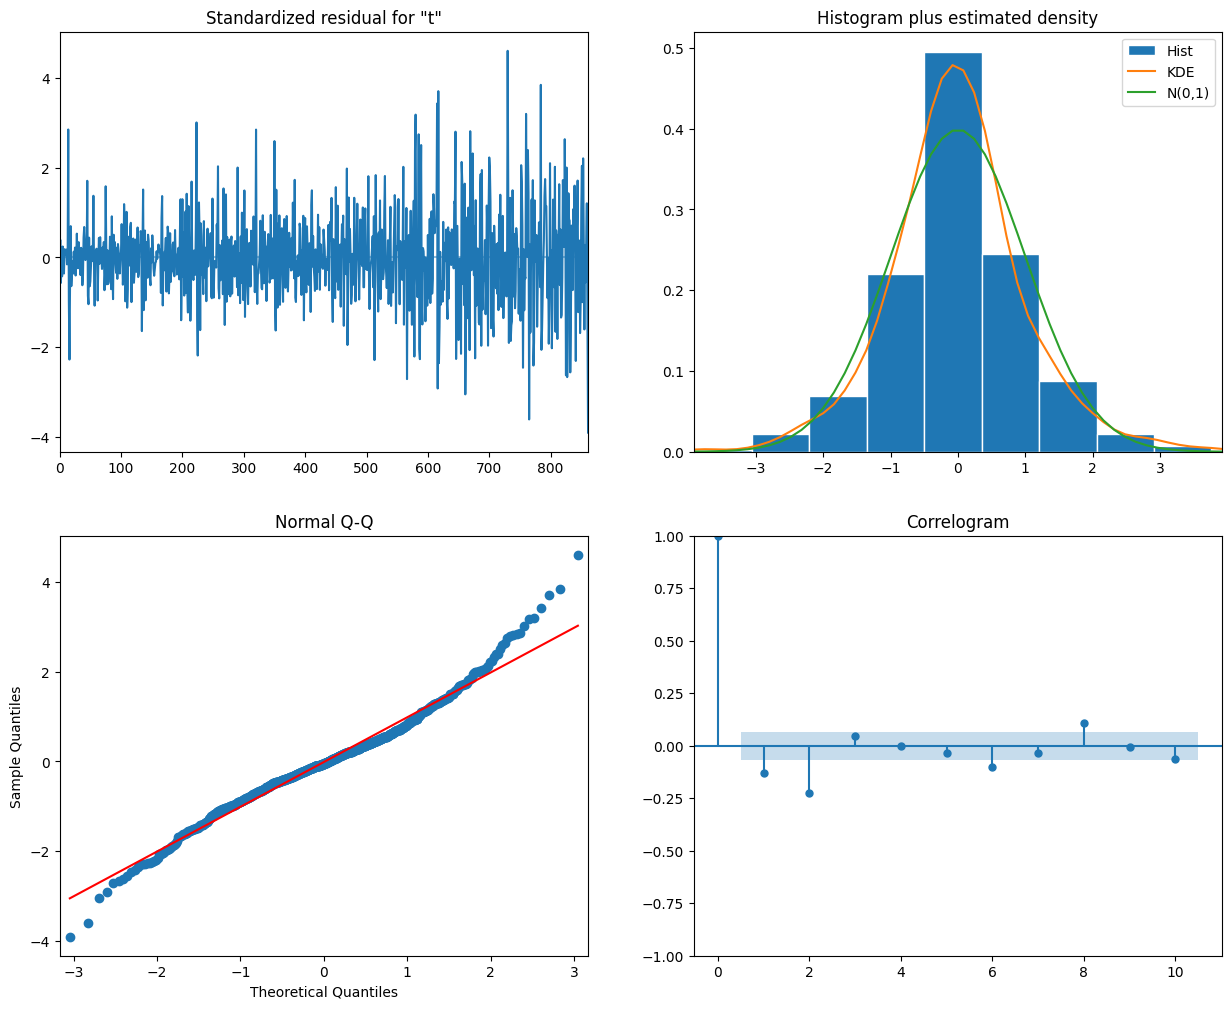

In [ ]:
print(round(results.aic,2))
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

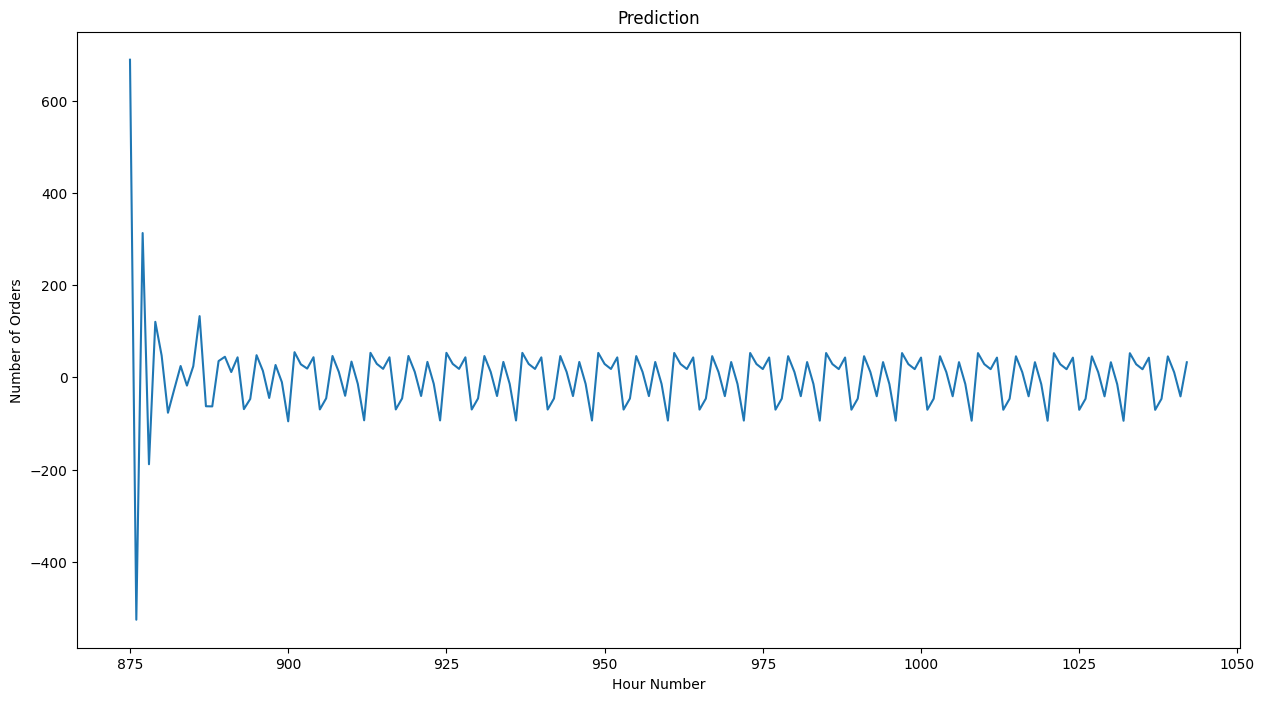

In [ ]:
# Get forecast one week ahead in future
pred_uc = results.get_forecast(steps=168)

plt.rcParams['figure.figsize'] = [15, 8]

plt.plot(pred_uc.predicted_mean)
# plt.plot(res[-168:], color='red') # compare with previous week
plt.xlabel('Hour Number')
plt.ylabel('Number of Orders')
plt.title('Prediction')
plt.show()

In [ ]:
# Forecast for next 30 days
forecast_sarima = model_sarima.forecast(30)




In [ ]:
mae_sarima = mean_absolute_error(test, predictions)
print('MAE: %f' % mae_sarima)
mse_sarima = mean_squared_error(test, predictions)
print('MSE: %f' % mse_sarima)
rmse_sarima = sqrt(mse_sarima)
print('RMSE: %f' % rmse_sarima)

MAE: 519.113849
MSE: 439477.540615
RMSE: 662.931023


In [ ]:
forecast = pd.DataFrame(forecast, columns=['total_amount_diff'])
forecast['total_amount'] = df['total_amount'].iloc[-1] + forecast['total_amount_diff'].cumsum()
forecast = forecast.drop('total_amount_diff', axis=1)
forecast = forecast.reset_index()
forecast = forecast.rename(columns={'index': 'ds'})
forecast['ds'] = forecast['ds'].apply(lambda x: x.date())


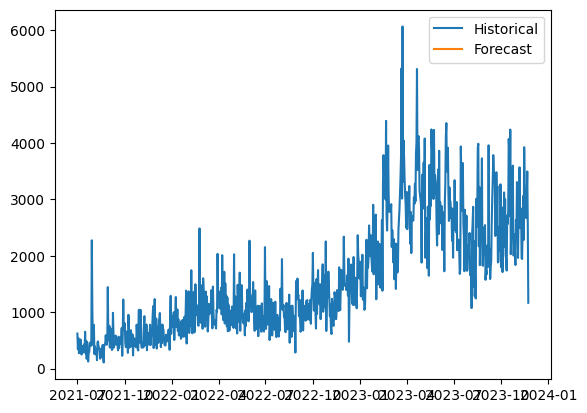

In [ ]:
#plot forecast
plt.plot(df['date'], df['total_amount'], label='Historical')
plt.plot(forecast['ds'], forecast['total_amount'], label='Forecast')
plt.legend()
plt.show()


LSTM and GRU

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and it has columns 'date' and 'total_amount'
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Split into train and test sets
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=2)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)



Epoch 1/10
611/611 - 14s - loss: 0.0100 - 14s/epoch - 22ms/step
Epoch 2/10
611/611 - 2s - loss: 0.0071 - 2s/epoch - 3ms/step
Epoch 3/10
611/611 - 2s - loss: 0.0057 - 2s/epoch - 3ms/step
Epoch 4/10
611/611 - 2s - loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 5/10
611/611 - 2s - loss: 0.0050 - 2s/epoch - 3ms/step
Epoch 6/10
611/611 - 2s - loss: 0.0050 - 2s/epoch - 3ms/step
Epoch 7/10
611/611 - 2s - loss: 0.0050 - 2s/epoch - 4ms/step
Epoch 8/10
611/611 - 2s - loss: 0.0049 - 2s/epoch - 3ms/step
Epoch 9/10
611/611 - 2s - loss: 0.0051 - 2s/epoch - 3ms/step
Epoch 10/10
611/611 - 2s - loss: 0.0050 - 2s/epoch - 3ms/step
9/9 [==============================] - 0s 3ms/step


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['total_amount'].values.reshape(-1,1))

# Rest of the code remains the same...

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

Train MSE: 175494.61506672457
Test MSE: 689716.24635803
Train RMSE: 418.92077421240947
Test RMSE: 830.4915691071343
Train MAE: 316.5211288527069
Test MAE: 653.3615544929359


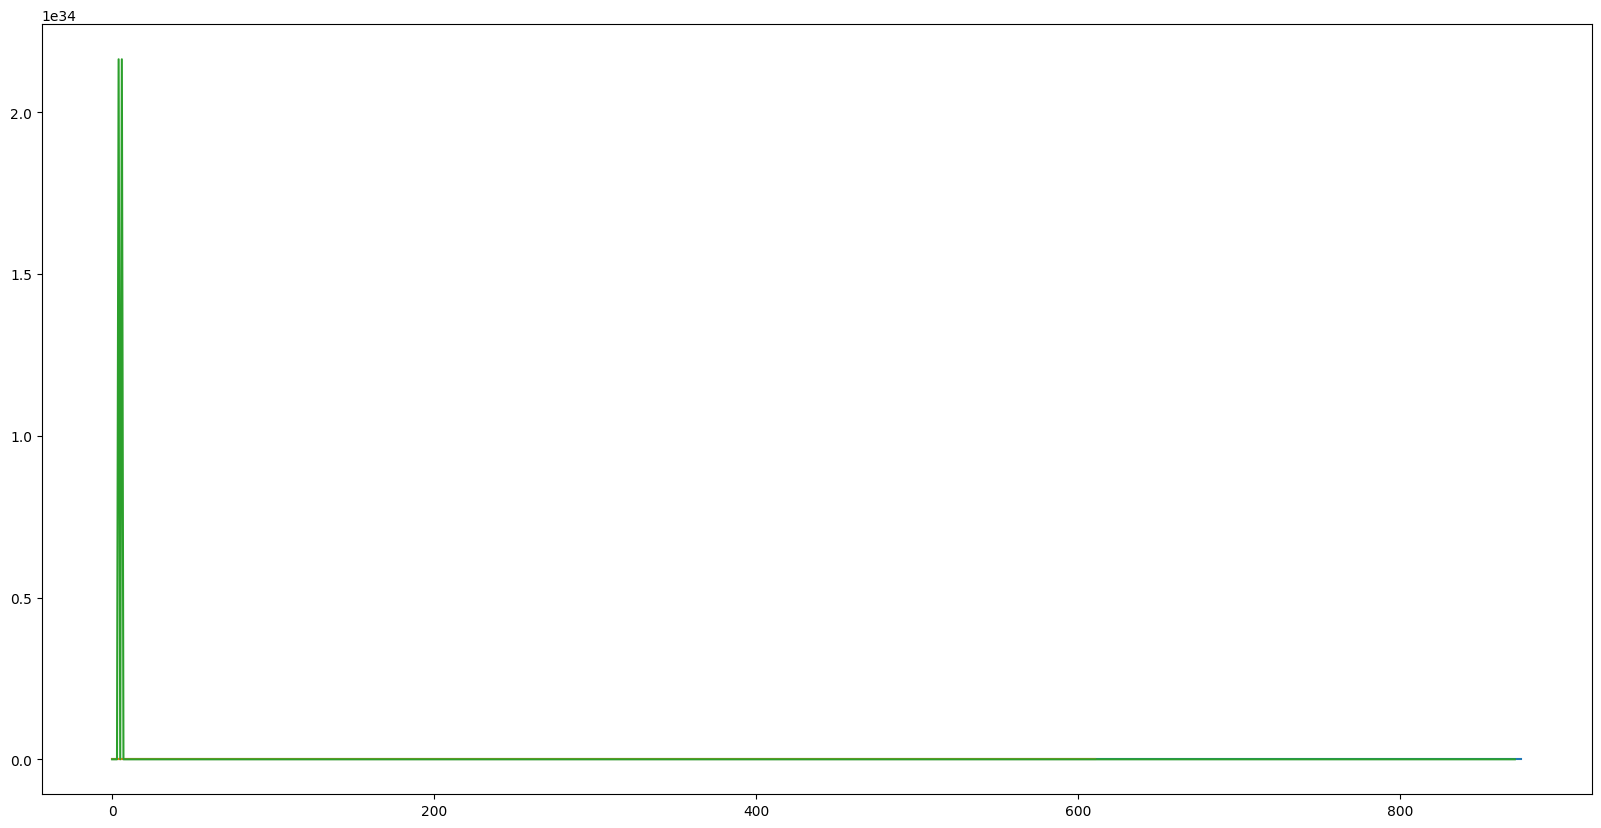

In [ ]:
# Calculate metrics
train_mse = mean_squared_error(Y_train.flatten(), train_predict[:,0])
test_mse = mean_squared_error(Y_test.flatten(), test_predict[:,0])

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {sqrt(train_mse)}')
print(f'Test RMSE: {sqrt(test_mse)}')
print(f'Train MAE: {mean_absolute_error(Y_train.flatten(), train_predict[:,0])}')
print(f'Test MAE: {mean_absolute_error(Y_test.flatten(), test_predict[:,0])}')

# Plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict)
plt.plot(np.append(np.empty_like(train_predict), test_predict))
plt.show()